In [1]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import scipy as sc
from itertools import compress

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

## Seizure Preprocessing

### Metadata table

In [2]:
metadata = pd.read_csv('../metadata_wchreject.csv')
# (metadata.cceps_hfs_seizure == 1) | 
metadata = metadata[(metadata.cceps_run1_sz == 1)].reset_index()
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'
len(metadata)
metadata.head()

,index,Unnamed: 0.1,Unnamed: 0,record_id,hupsubjno,ageatieegimplant,ieeg_ictal_onset_electrodes,ieeg_ictal_onset_anat_lat,ieeg_ictal_onset_anat_spec,cceps_run1_home_meds,...,cceps_run1_soz_electrodes,cceps_run1_seizure_typical,cceps_hfs_done,cceps_hfs_seizure,cceps_hfs_stim_elec_sz,cceps_hfs_sz_typical,manual_reject_channels,final_reject_channels,ieeg_id,ccep_id
0,23,23,23,617.0,224,42.0,"RB2, RB3, RC2",2.0,hippocampus,0.0,...,"LB1, LB2, LB3, LB4, LB5, LC1, LC2, LC3, LC4, L...",2.0,2.0,2.0,NaN,NaN,NaN,"LZ06, RB10, RF06, RB05, RA10, LB08",HUP224_phaseII,HUP224_CCEP
1,24,24,24,700.0,225,33.0,"RT4, RT5",2.0,temporal neocortex,0.0,...,"RB1, RB2, RB3, RB4",1.0,1.0,2.0,NaN,NaN,"RA09, RT01","RT01, RA09",HUP225_phaseII,HUP225_CCEP
2,26,26,26,835.0,229,40.0,"LB1, LB2, LA1, LA2",1.0,mesial temporal,1.0,...,"LB1, LB2, LC1, LC2, LC3",1.0,2.0,2.0,NaN,NaN,NaN,NaN,HUP229_phaseII,HUP229_CCEP
3,27,27,27,808.0,230,51.0,"LC1, LC2, LC3, LB1, LB2",1.0,hippocampus,1.0,...,"LC1, LC2, LC3, LC4",3.0,2.0,2.0,NaN,NaN,"LB05,LB06","LB05,LB06",HUP230_phaseII,HUP230_CCEP
4,28,28,28,796.0,235,24.0,"LC1, LC2, LB2, LB3",1.0,hippocampal tail/body,1.0,...,"LA1, LA2, LA3, LB1, LB2, LB3, LC1, LC2, LC3, L...",1.0,1.0,1.0,LA1,1.0,"LA01,LA02,LA04,LA05","LA01,LA02,LA04,LA05",HUP235_phaseII,HUP235_CCEP


In [3]:
metadata['manual_reject_channels'].fillna("",inplace=True)
metadata['manual_reject_channels'].str.split(",")

0                                                    []
1                                         [RA09,  RT01]
2                                                    []
3                                          [LB05, LB06]
4                              [LA01, LA02, LA04, LA05]
5     [LA04, LA05, LC02, LC03, LE01, LE02, LE03, LE0...
6                                                    []
7                                    [RP02, RP03, RY11]
8                                          [RB01, RB02]
9                                          [LB03, LB04]
10                                         [RB02, RB03]
Name: manual_reject_channels, dtype: object

### Pulling patient metadata

In [4]:
def optimize_localizations(path_to_recon,RID):
    # /mnt/leif/littlab/data/Human_Data/recon/BIDS_penn/
    # python /mnt/leif/littlab/data/Human_Data/recon/code/run_penn_recons.py
    
    atropos_metadata = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
    localization_probs = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
    localization_metadata = pd.read_csv(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.csv')
    def _apply_function(x):
        # look in labels sorted and see if it contains gray matter
        # if gray matter is greater than 5% then set label to gray matter
        x = pd.DataFrame(x).transpose()
        for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
            if (label == 'gray matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 2
                continue
            elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 3
        
        return x

    modified_atropos = atropos_metadata.iloc[:,:].apply(lambda x: _apply_function(x), axis = 1)
    modified_atropos_df = pd.DataFrame(np.squeeze(np.array(modified_atropos.to_list())),columns=atropos_metadata.columns)
    return modified_atropos_df

In [5]:
np.random.seed(42)
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
ieeg_list = CONFIG["patients"]
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = np.unique(np.array([i.split("_")[0] for i in ieeg_list]))
# Iterate through each patient
for pt in ["HUP235"]:
    print(pt)
    raw_datapath = ospj(datapath,pt)
    # load dataframe of seizure times
    seizure_times = pd.read_csv(ospj(raw_datapath,f"seizure_times_{pt}.csv"))
    # load electrode information
    if not os.path.exists(ospj(raw_datapath, "electrode_localizations.csv")):
        hup_no = pt[3:]
        rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
        recon_path = ospj('/mnt','leif','littlab','data',
                          'Human_Data','CNT_iEEG_BIDS',
                          f'sub-RID0{rid}','derivatives','ieeg_recon',
                          'module3/')
        if not os.path.exists(recon_path):
            recon_path =  ospj('/mnt','leif','littlab','data',
                          'Human_Data','recon','BIDS_penn',
                          f'sub-RID0{rid}','derivatives','ieeg_recon',
                          'module3/')
        electrode_localizations = optimize_localizations(recon_path,rid)
        electrode_localizations.to_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    else:    
        electrode_localizations = pd.read_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    ch_names = electrode_localizations[(electrode_localizations['index'] == 2) | (electrode_localizations['index'] == 3)]["name"]
    
    ch_names_clean = clean_labels(ch_names,pt)
    dirty_drop_electrodes = metadata[metadata.hupsubjno == int(pt[-3:])]["final_reject_channels"].str.split(',').to_list()[0]
    print(dirty_drop_electrodes)
    if isinstance(dirty_drop_electrodes,list):
        final_drop_electrodes = clean_labels(dirty_drop_electrodes,pt)
    else:
        final_drop_electrodes = []
    ch_names_clean = [ch for ch in ch_names_clean if ch not in final_drop_electrodes]

    if not os.path.exists(ospj(raw_datapath, "seizures")):
        os.mkdir(ospj(raw_datapath, "seizures"))

HUP235
['LA01', 'LA02', 'LA04', 'LA05']


In [6]:
metadata[metadata.hupsubjno == int(pt[-3:])]

,index,Unnamed: 0.1,Unnamed: 0,record_id,hupsubjno,ageatieegimplant,ieeg_ictal_onset_electrodes,ieeg_ictal_onset_anat_lat,ieeg_ictal_onset_anat_spec,cceps_run1_home_meds,...,cceps_run1_soz_electrodes,cceps_run1_seizure_typical,cceps_hfs_done,cceps_hfs_seizure,cceps_hfs_stim_elec_sz,cceps_hfs_sz_typical,manual_reject_channels,final_reject_channels,ieeg_id,ccep_id
4,28,28,28,796.0,235,24.0,"LC1, LC2, LB2, LB3",1.0,hippocampal tail/body,1.0,...,"LA1, LA2, LA3, LB1, LB2, LB3, LC1, LC2, LC3, L...",1.0,1.0,1.0,LA1,1.0,"LA01,LA02,LA04,LA05","LA01,LA02,LA04,LA05",HUP235_phaseII,HUP235_CCEP


In [7]:
ch_names_clean

['LA03',
 'LA06',
 'LA07',
 'LA08',
 'LA09',
 'LA10',
 'LB01',
 'LB02',
 'LB03',
 'LB04',
 'LB05',
 'LB06',
 'LB07',
 'LB08',
 'LB09',
 'LB10',
 'LB11',
 'LC01',
 'LC02',
 'LC03',
 'LC04',
 'LC05',
 'LC06',
 'LC07',
 'LC08',
 'LC09',
 'LI01',
 'LI02',
 'LI03',
 'LI04',
 'LI05',
 'LI06',
 'LI07',
 'LI08',
 'LQ01',
 'LQ02',
 'LQ03',
 'LQ04',
 'LQ05',
 'LQ06',
 'LQ07',
 'LS01',
 'LS02',
 'LS03',
 'LS04',
 'LS05',
 'LS06',
 'LS07',
 'LS08',
 'LS09',
 'LS10',
 'LS11',
 'LS12',
 'LY01',
 'LY02',
 'LY03',
 'LY04',
 'LY05',
 'LY06',
 'LY07',
 'LY08',
 'LY09',
 'LY10',
 'LZ01',
 'LZ02',
 'LZ03',
 'LZ04',
 'LZ05',
 'LZ06',
 'LZ07',
 'LZ08',
 'LZ09',
 'LZ10',
 'LZ11']

### Pulling and saving seizures

Pipeline:
Pull raw seizure (plus 15 seconds prior to seizure onset)
if not stim:
    Detect bad channels (noisy, nans, zeros)
if lfstim:
    run detect bad channels and manually parse
    use manual stim rejection channels
if hf stim:
    reject stim channel
    Detect bad channels
Store detected bad channels in master dictionary
apply notch filter
apply bandpass filter (1-200)
run artifact detection algorithm
fill in individaul channels/gaps with artifact in them
make master list for channel masking


In [21]:
# Code for within each patient's for loop
with open(passpath, "r") as f:
        pwd = f.read()
s = Session(usr, pwd)
ds = s.open_dataset(pt+"_phaseII")
all_channel_labels = ds.get_channel_labels()
# making sure all channels are in iEEG file
final_drop_electrodes += [ch for ch in ch_names_clean if ch not in all_channel_labels]
# removing any channels that don't meet criteria
ch_names_clean = [ch for ch in ch_names_clean if ch not in final_drop_electrodes]
for i_sz,row in seizure_times.iterrows():
    if i_sz != 5:
        continue
    if os.path.exists(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl")):
        buffered_seizure = pd.read_pickle(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl"))
        fs = buffered_seizure.fs.to_numpy()[-1]
        cols = buffered_seizure.columns
        mask = (pd.isna(buffered_seizure.fs) | buffered_seizure.fs == 0 | np.isnan(buffered_seizure.fs))
        buffer = buffered_seizure.loc[mask,ch_names_clean]
        seizure = buffered_seizure.loc[~mask,ch_names_clean]
        t = np.arange(0,len(seizure)/fs,1/fs)
        break
    # else:
    #     seizure,fs = get_iEEG_data(usr,pass_path,
    #                                 row.IEEGname,
    #                                 row.start*1e6,
    #                                 row.end*1e6,
    #                                 ch_names_clean,
    #                                 force_pull=True)
    #     t = np.arange(0,len(seizure)/fs,1/fs)
    #     save_seizure = pd.concat((seizure,pd.DataFrame(np.ones(len(seizure),)*fs,columns=['fs'])),axis = 1)
    #     save_seizure.to_pickle(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl"),index=False)
    #     break

(<Figure size 499.967x1480 with 1 Axes>, <Axes: xlabel='Time (s)'>)

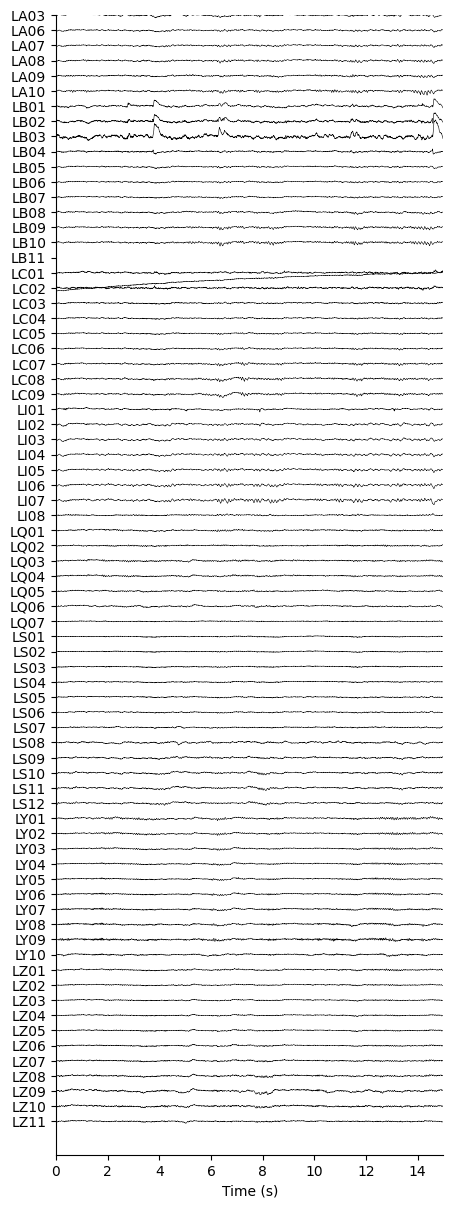

In [22]:
plot_iEEG_data(buffer,np.arange(0,len(buffer)/fs,1/fs))

(<Figure size 738.574x1480 with 1 Axes>, <Axes: xlabel='Time (s)'>)

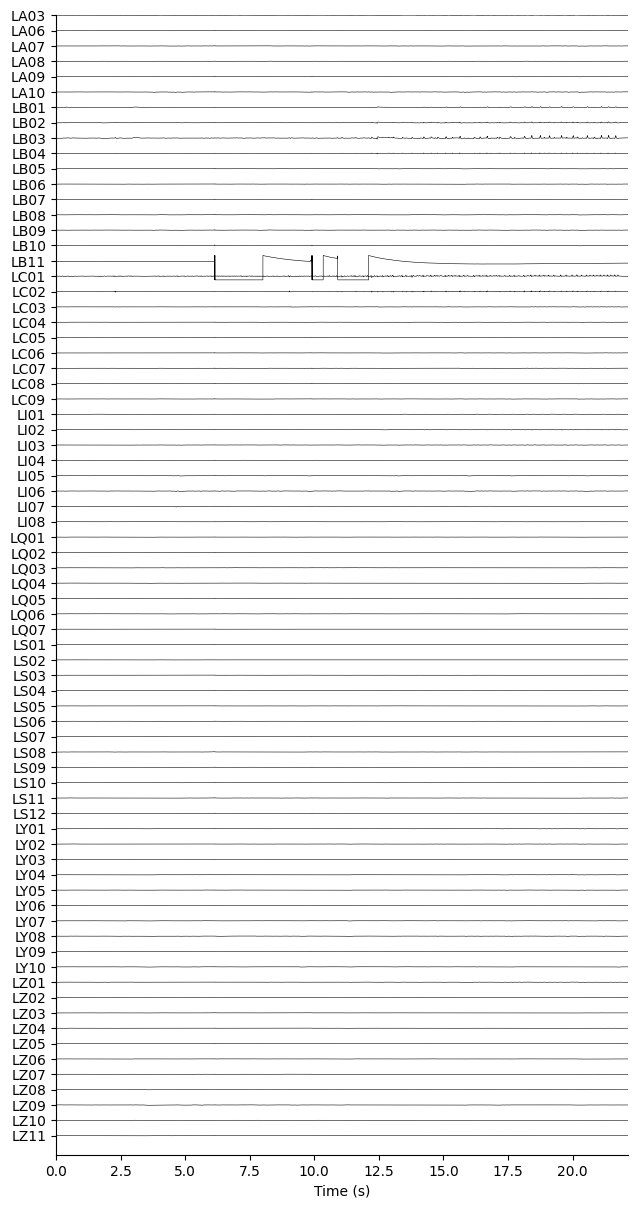

In [23]:
plot_iEEG_data(seizure,t)

### Channel Rejection

In [24]:
reject_mask,reject_details = detect_bad_channels(seizure.to_numpy(),fs,True)
# want channel name associated with the 
print({key: [ch_names_clean [ch] for ch in reject_details[key]] for key in reject_details.keys()})
np.where(~reject_mask)

{'noisy': [], 'nans': [], 'zeros': [], 'flat': ['LB11'], 'var': [], 'higher_std': ['LB11'], 'high_voltage': ['LB11']}


(array([16]),)

### Filtering

In [25]:
reject_mask,reject_details = detect_bad_channels(seizure.to_numpy(),fs)
reject_mask = np.ones((seizure.shape[1],),dtype=bool)

processed_seizure = seizure.loc[:,reject_mask]
reject_details

{'noisy': [],
 'nans': [],
 'zeros': [],
 'flat': [16],
 'var': [],
 'higher_std': array([16]),
 'high_voltage': [16]}

In [146]:
ch_names_rejected = list(compress(ch_names_clean,reject_mask))


In [26]:
# Here is where we need to add the mechanism to update the "total channel list" for all channels that work
# It will need to combine with the previously determined manual channels for the stim seizures
final_drop_electrodes += list(compress(ch_names_clean,~reject_mask))

In [148]:
# plot_iEEG_data(seizure.iloc[:,reject_details['high_voltage']],t)

In [149]:
# notch_seizure = notch_filter(rseizure.to_numpy(),fs)
# band_seizure = bandpass_filter(notch_seizure,fs)
# # car_seizure = band_seizure - np.mean(band_seizure, axis=0)
# processed_seizure = pd.DataFrame(band_seizure,columns=rseizure.columns)

In [150]:
# plot_iEEG_data(processed_seizure,t)

### Stim Artifact Removal

In [168]:
def artifact_removal(
    data: np.ndarray, fs: float, discon=1 / 12, noise=5000, win_size=1
) -> np.ndarray:
    """_summary_

    Args:
        data pandas
        fs (float): _description_
        discon (_type_, optional): _description_. Defaults to 1/12.
        noise (int, optional): _description_. Defaults to 15000.
        win_size (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: _description_
    """
    win_size = int(win_size * fs)
    
    n_wins = np.ceil(data.shape[0]/win_size)
    max_inds = n_wins*win_size
     
    all_inds = np.arange(max_inds)
    all_inds[data.shape[0]:] = np.nan
    ind_overlap = np.reshape(all_inds, (-1, int(win_size)))
    
    artifacts = np.empty_like(data)

    # mask indices with nan values
    artifacts = np.isnan(data)
    noisy = np.isnan(data)
    disco = np.isnan(data)

    for win_inds in ind_overlap:
        win_inds = win_inds[~np.isnan(win_inds)].astype(int)
        is_disconnected = np.sum(np.abs(data[win_inds,:]), axis=0) < discon

        is_noise = (
            np.sqrt(np.sum(np.power(np.diff(data[win_inds,:], axis=0), 2), axis=0))
            > noise
        )

        artifacts[win_inds, :] = np.logical_or(
            artifacts[win_inds, :].any(axis=0), np.logical_or(is_disconnected, is_noise)
        )
        noisy[win_inds,:] = is_noise
        disco[win_inds,:] = is_disconnected

    return artifacts,noisy,disco

In [169]:
# art_idxs,noisy,disco = artifact_removal(processed_seizure.to_numpy(),fs,win_size = .1,
#                  noise = np.abs(np.mean(processed_seizure)) + 10*np.std(processed_seizure))
art_idxs,noisy,disco = artifact_removal(processed_seizure.to_numpy(),fs,win_size = .1,noise=1000)

In [170]:
art_ch_reject = list(compress(ch_names_rejected,np.sum(art_idxs,axis=0)/len(art_idxs) > 0.1))
art_ch_reject

['RP01',
 'RP04',
 'RP05',
 'RP06',
 'RP07',
 'RV01',
 'RV02',
 'RV03',
 'RV04',
 'RV05',
 'RV06',
 'RV07',
 'RV08',
 'RV09',
 'RW01',
 'RW02',
 'RW03',
 'RW04',
 'RW05',
 'RW06',
 'RW07',
 'RX01',
 'RX02',
 'RX03',
 'RX04',
 'RX05',
 'RX06',
 'RX07',
 'RX08',
 'RX09',
 'RX10',
 'RX11',
 'RX12',
 'RY01',
 'RY02',
 'RY03',
 'RY04',
 'RY05',
 'RY07']

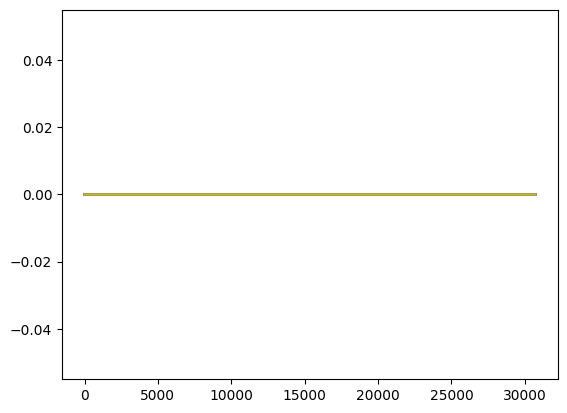

In [172]:
plt.plot(noisy);

In [155]:
# artifact_mask = sig.medfilt(art_idxs.astype(int),(3,1))
# stim_idxs = [np.reshape(np.where(np.diff(artifact_mask[:,ch],prepend=0)),(-1,2))for ch in range(art_idxs.shape[1])]
artifact_mask = sig.medfilt(art_idxs.any(1).astype(int),5)
stim_idxs = np.reshape(np.where(np.diff(artifact_mask,prepend=0)),(-1,2))
s = processed_seizure.copy().to_numpy()



ValueError: cannot reshape array of size 1 into shape (2)

In [118]:
np.random.seed(42)
for i_ch in range(sum(reject_mask)):
    for win in stim_idxs:
        win_len = win[1]-win[0]
        pre_idx = win[0] - win_len
        post_idx = win[1] + win_len
        if post_idx > len(s):
            post_idx = win[1]
        # Plotting raw signal
        # plot_seg = processed_seizure.iloc[pre_idx:post_idx,i_ch].to_numpy()
        # plt.figure()
        # plt.plot(t[np.arange(pre_idx,post_idx)],plot_seg)
        # plt.vlines([(win_len + pre_idx)/fs, (2*win_len+pre_idx)/fs],plot_seg.min(),plot_seg.max())

        # Interpolation parameters
        pre_idxs = np.arange(pre_idx,win[0])
        post_idxs = np.arange(win[1],post_idx)
        fill_idxs = np.arange(win[0],win[1])

        # Interpolation
        # check for edge cases
        if win[0] < win_len:
            pre_t = np.arange((pre_idx)/fs,(win[0])/fs,1/fs)
            post_t = t[post_idxs]
            pre_win = buffer.loc[:,ch_names_clean[i_ch]].to_numpy()[pre_idxs]
            post_win = s[post_idxs,i_ch]

        elif post_idx > len(s):
            pre_win = s[pre_idxs,i_ch]
            pre_t = t[pre_idxs]
            post_win = pre_win
            post_t = pre_t
        else:
            pre_win = s[pre_idxs,i_ch]
            pre_t = t[pre_idxs]
            post_win = s[post_idxs,i_ch]
            post_t = t[post_idxs]
        interp_fn = sc.interpolate.interp1d(np.concatenate([pre_t,t[post_idxs]]),
                                np.concatenate([pre_win,post_win]))
        # run interpolation
        filled_s = interp_fn(t[fill_idxs])

        # Adding noise to interpolation
        sample_std = (np.std(pre_win) + np.std(s[post_idxs,i_ch]))/8
        
        interp_samples = np.random.normal(filled_s,np.ones_like(filled_s)*sample_std)

        # # # Plotting interpolation
        # plt.figure()
        # plt.plot(t[pre_idxs],s[pre_idxs,i_ch],color='k')
        # plt.plot(t[fill_idxs],filled_s,color='r')
        # plt.plot(t[post_idxs],s[post_idxs,i_ch],color='k')
        # plt.plot(t[fill_idxs],sc.ndimage.gaussian_filter1d(interp_samples,2),color='b')
        
        s[win[0]:win[1],i_ch] = interp_samples

ValueError: A value (36.556640625) in x_new is above the interpolation range's maximum value (36.5556640625).

In [30]:
# cols = ch_names_clean
# cols.append('fs')
# postrejection_seizure = pd.DataFrame(np.concatenate((s,np.ones((len(s,),1))*fs),axis=1), columns = cols)

In [31]:
# postrejection_seizure.head()

In [32]:
# plot_iEEG_data(s,t)

In [33]:
notch_seizure = notch_filter(s,fs)
band_seizure = bandpass_filter(notch_seizure,fs)
car_seizure = band_seizure - np.mean(band_seizure, axis=0)
filtered_seizure = pd.DataFrame(car_seizure,columns=processed_seizure.columns)

ValueError: The length of the input vector x must be greater than padlen, which is 21.

In [34]:
plot_iEEG_data(filtered_seizure,t)

NameError: name 'filtered_seizure' is not defined